In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms

import time
import os
import copy

/Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/raymondzhou/miniforge3/lib/python3.9/lib-dynload/../../libpng16.16.dylib' (no such file), '/Users/raymondzhou/miniforge3/bin/../lib/libpng16.16.dylib' (no such file), '/usr/local/lib/libpng16.16.dylib' (no such file), '/usr/lib/libpng16.16.dy

In [2]:
# Top level data directory
data_dir = "/Users/raymondzhou/CelebA/celebA/Img"

# Number of classes in the dataset
num_classes = 2

# Batch size for training
batch_size = 8

# Number of epochs to train for
num_epochs = 5

# Flag for feature extracting. When True, only update reshaped layer params 
# When False, finetune the whole model, 
feature_extract = False

In [3]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [4]:
def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 224

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained=True)
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, 
                                                   num_workers=4) for x in ['train', 'val']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [7]:
# Send the model to GPU
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print(name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print(name)

optimizer_ft = optim.AdamW(params_to_update)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [8]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/4
----------


/Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/raymondzhou/miniforge3/lib/python3.9/lib-dynload/../../libpng16.16.dylib' (no such file), '/Users/raymondzhou/miniforge3/bin/../lib/libpng16.16.dylib' (no such file), '/usr/local/lib/libpng16.16.dylib' (no such file), '/usr/lib/libpng16.16.dy

train Loss: 0.1095 Acc: 0.9595


/Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/raymondzhou/miniforge3/lib/python3.9/lib-dynload/../../libpng16.16.dylib' (no such file), '/Users/raymondzhou/miniforge3/bin/../lib/libpng16.16.dylib' (no such file), '/usr/local/lib/libpng16.16.dylib' (no such file), '/usr/lib/libpng16.16.dy

val Loss: 0.0602 Acc: 0.9781

Epoch 1/4
----------


/Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/raymondzhou/miniforge3/lib/python3.9/lib-dynload/../../libpng16.16.dylib' (no such file), '/Users/raymondzhou/miniforge3/bin/../lib/libpng16.16.dylib' (no such file), '/usr/local/lib/libpng16.16.dylib' (no such file), '/usr/lib/libpng16.16.dy

train Loss: 0.0663 Acc: 0.9760


/Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/raymondzhou/miniforge3/lib/python3.9/lib-dynload/../../libpng16.16.dylib' (no such file), '/Users/raymondzhou/miniforge3/bin/../lib/libpng16.16.dylib' (no such file), '/usr/local/lib/libpng16.16.dylib' (no such file), '/usr/lib/libpng16.16.dy

val Loss: 0.0553 Acc: 0.9791

Epoch 2/4
----------


/Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/raymondzhou/miniforge3/lib/python3.9/lib-dynload/../../libpng16.16.dylib' (no such file), '/Users/raymondzhou/miniforge3/bin/../lib/libpng16.16.dylib' (no such file), '/usr/local/lib/libpng16.16.dylib' (no such file), '/usr/lib/libpng16.16.dy

train Loss: 0.0565 Acc: 0.9805


/Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/raymondzhou/miniforge3/lib/python3.9/lib-dynload/../../libpng16.16.dylib' (no such file), '/Users/raymondzhou/miniforge3/bin/../lib/libpng16.16.dylib' (no such file), '/usr/local/lib/libpng16.16.dylib' (no such file), '/usr/lib/libpng16.16.dy

val Loss: 0.0483 Acc: 0.9830

Epoch 3/4
----------


/Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/raymondzhou/miniforge3/lib/python3.9/lib-dynload/../../libpng16.16.dylib' (no such file), '/Users/raymondzhou/miniforge3/bin/../lib/libpng16.16.dylib' (no such file), '/usr/local/lib/libpng16.16.dylib' (no such file), '/usr/lib/libpng16.16.dy

train Loss: 0.0501 Acc: 0.9822


/Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/raymondzhou/miniforge3/lib/python3.9/lib-dynload/../../libpng16.16.dylib' (no such file), '/Users/raymondzhou/miniforge3/bin/../lib/libpng16.16.dylib' (no such file), '/usr/local/lib/libpng16.16.dylib' (no such file), '/usr/lib/libpng16.16.dy

val Loss: 0.0440 Acc: 0.9843

Epoch 4/4
----------


/Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/raymondzhou/miniforge3/lib/python3.9/lib-dynload/../../libpng16.16.dylib' (no such file), '/Users/raymondzhou/miniforge3/bin/../lib/libpng16.16.dylib' (no such file), '/usr/local/lib/libpng16.16.dylib' (no such file), '/usr/lib/libpng16.16.dy

train Loss: 0.0454 Acc: 0.9841


/Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/raymondzhou/miniforge3/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/malfet/miniforge3/envs/py_39_torch-1.10.2/lib/libpng16.16.dylib' (no such file), '/Users/raymondzhou/miniforge3/lib/python3.9/lib-dynload/../../libpng16.16.dylib' (no such file), '/Users/raymondzhou/miniforge3/bin/../lib/libpng16.16.dylib' (no such file), '/usr/local/lib/libpng16.16.dylib' (no such file), '/usr/lib/libpng16.16.dy

val Loss: 0.0414 Acc: 0.9857

Training complete in 414m 35s
Best val Acc: 0.985705


In [9]:
torch.save(model_ft, "resnet_bsize8_epoch5_full.pt")

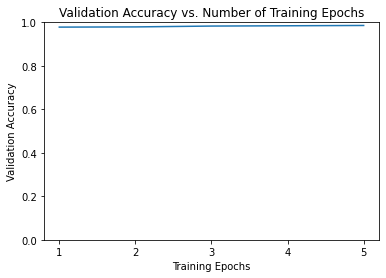

In [14]:
ohist = [h.cpu().numpy() for h in hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1, num_epochs+1), ohist)
plt.ylim((0, 1))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.show()